In [4]:
!mkdir "%userprofile%\.kaggle"
!copy kaggle.json "%userprofile%\.kaggle"


        1 file(s) copied.


In [9]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset 

... resuming from 0 bytes (155791278 bytes left) ...




  0%|          | 0.00/149M [00:00<?, ?B/s]
  1%|          | 1.00M/149M [00:01<03:47, 681kB/s]
  1%|1         | 2.00M/149M [00:01<01:52, 1.37MB/s]
  2%|2         | 3.00M/149M [00:01<01:09, 2.18MB/s]
  3%|2         | 4.00M/149M [00:02<00:47, 3.17MB/s]
  4%|4         | 6.00M/149M [00:02<00:27, 5.50MB/s]
  5%|5         | 8.00M/149M [00:02<00:19, 7.67MB/s]
  7%|6         | 10.0M/149M [00:02<00:15, 9.57MB/s]
  8%|8         | 12.0M/149M [00:02<00:12, 11.1MB/s]
  9%|9         | 14.0M/149M [00:02<00:11, 12.5MB/s]
 11%|#         | 16.0M/149M [00:02<00:10, 13.3MB/s]
 12%|#2        | 18.0M/149M [00:02<00:09, 14.3MB/s]
 13%|#3        | 20.0M/149M [00:03<00:09, 14.5MB/s]
 15%|#4        | 22.0M/149M [00:03<00:08, 15.2MB/s]
 16%|#6        | 24.0M/149M [00:03<00:08, 15.1MB/s]
 17%|#7        | 26.0M/149M [00:03<00:08, 15.0MB/s]
 19%|#8        | 28.0M/149M [00:03<00:08, 15.6MB/s]
 20%|##        | 30.0M/149M [00:03<00:07, 15.9MB/s]
 22%|##1       | 32.0M/149M [00:03<00:07, 16.1MB/s]
 23%|##2       | 34.0

In [10]:
import zipfile
zip_ref=zipfile.ZipFile('brain-tumor-mri-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

In [11]:
import tensorflow as tf
from keras.layers import Activation,Conv2D,Flatten,Dense,MaxPooling2D,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [12]:
train_dir='Training'
valid_dir='Testing'
batch_size=16
img_rows,img_cols=128,128
num_classes=4


train_data_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_data_gen=ImageDataGenerator(
    rescale=1./255
)

train_generator=train_data_gen.flow_from_directory(
    train_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

valid_generator=valid_data_gen.flow_from_directory(
    valid_dir,
    target_size=(img_rows,img_cols),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [13]:
model=Sequential()
model.add(Conv2D(512, (3, 3), padding='same',input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(units=num_classes,activation='softmax'))


print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 512)     14336     
                                                                 
 activation (Activation)     (None, 128, 128, 512)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 512)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       1179904   
                                                                 
 activation_1 (Activation)   (None, 64, 64, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 256)       0         
 g2D)                                                   

In [14]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint=ModelCheckpoint(
    'brain_tumor.h5',
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

earlystopping=EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    restore_best_weights=True
)

reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.01,
    patience=3,
    min_delta=0.0001,
    
)

callbacks=[earlystopping,checkpoint,reduce_lr]

model.compile(loss='categorical_crossentropy',optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])
num_train_samples=5712
num_valid_samples=1311
epochs=9

history=model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    callbacks=callbacks,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=num_valid_samples//batch_size

)

C:\Users\puzan12\AppData\Local\Temp\ipykernel_24068\2232306394.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(


Epoch 1/9
357/357 [==============================] - ETA: 0s - loss: 1.0989 - accuracy: 0.5289
Epoch 1: val_loss improved from inf to 2.08838, saving model to brain_tumor.h5
357/357 [==============================] - 1277s 4s/step - loss: 1.0989 - accuracy: 0.5289 - val_loss: 2.0884 - val_accuracy: 0.3727 - lr: 0.0010
Epoch 2/9


C:\Users\puzan12\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


357/357 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.6623
Epoch 2: val_loss improved from 2.08838 to 1.87035, saving model to brain_tumor.h5
357/357 [==============================] - 1255s 4s/step - loss: 0.8406 - accuracy: 0.6623 - val_loss: 1.8703 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 3/9
357/357 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.7054
Epoch 3: val_loss improved from 1.87035 to 1.21494, saving model to brain_tumor.h5
357/357 [==============================] - 1251s 4s/step - loss: 0.7403 - accuracy: 0.7054 - val_loss: 1.2149 - val_accuracy: 0.6312 - lr: 0.0010
Epoch 4/9
357/357 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.7307
Epoch 4: val_loss improved from 1.21494 to 1.07415, saving model to brain_tumor.h5
357/357 [==============================] - 1255s 4s/step - loss: 0.6886 - accuracy: 0.7307 - val_loss: 1.0742 - val_accuracy: 0.6551 - lr: 0.0010
Epoch 5/9
357/357 [===================

In [15]:
history.history

{'loss': [1.0988620519638062,
  0.8406121730804443,
  0.7403354048728943,
  0.6885542869567871,
  0.6285567283630371,
  0.6050188541412354,
  0.5626261830329895,
  0.5432602763175964,
  0.5170217156410217],
 'accuracy': [0.5288865566253662,
  0.6622899174690247,
  0.7053571343421936,
  0.7307422757148743,
  0.7533263564109802,
  0.7718837261199951,
  0.788165271282196,
  0.8039215803146362,
  0.8102241158485413],
 'val_loss': [2.088381767272949,
  1.8703486919403076,
  1.2149362564086914,
  1.0741548538208008,
  0.7597926259040833,
  0.6346596479415894,
  0.6814054846763611,
  0.527084231376648,
  0.8859490156173706],
 'val_accuracy': [0.37268519401550293,
  0.4266975224018097,
  0.6311728358268738,
  0.6550925970077515,
  0.7214506268501282,
  0.6975308656692505,
  0.720678985118866,
  0.772376537322998,
  0.7330247163772583],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

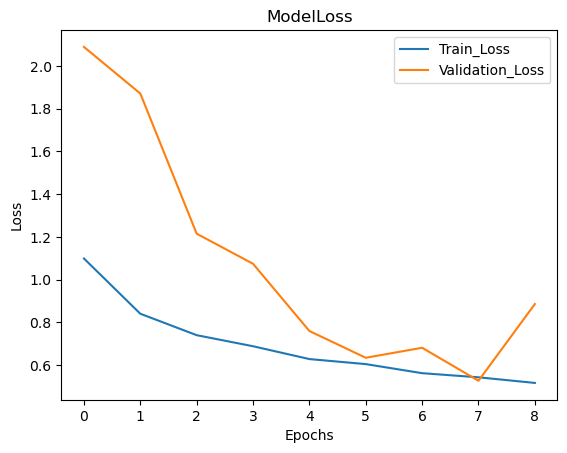

In [19]:
# plotting Training and validation loss
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ModelLoss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train_Loss','Validation_Loss'],loc='upper right')
plt.show()

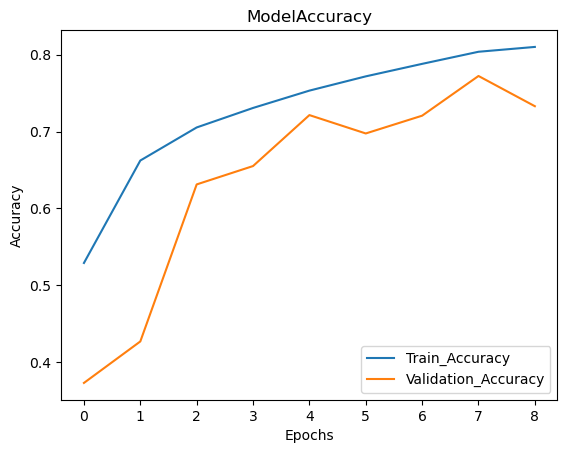

In [21]:
# plotting Training and validation accuracy
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ModelAccuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train_Accuracy','Validation_Accuracy'],loc='lower right')
plt.show()

In [22]:
class_indices = train_generator.class_indices
print("Class indices:", class_indices)


Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [29]:
from sklearn.metrics import classification_report,confusion_matrix
target_names=list(class_indices.keys())

y_pred=model.predict_generator(valid_generator,num_valid_samples//batch_size+1)
y_pred=np.argmax(y_pred,axis=1) # gives highest predicted value for axis 1 in each row
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes,y_pred))

print("Classification Report")
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))


C:\Users\puzan12\AppData\Local\Temp\ipykernel_24068\318036276.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred=model.predict_generator(valid_generator,num_valid_samples//batch_size+1)


Confusion Matrix
[[ 36  34 136  94]
 [ 36  58 146  66]
 [ 61  65 185  94]
 [ 32  55 143  70]]
Classification Report
              precision    recall  f1-score   support

      glioma       0.22      0.12      0.15       300
  meningioma       0.27      0.19      0.22       306
     notumor       0.30      0.46      0.36       405
   pituitary       0.22      0.23      0.22       300

    accuracy                           0.27      1311
   macro avg       0.25      0.25      0.24      1311
weighted avg       0.26      0.27      0.25      1311



1/1 [==============================] - 0s 275ms/step
[[0. 0. 1. 0.]]
2
The category =  notumor


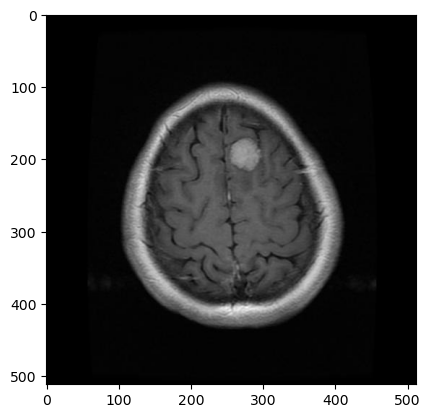

In [34]:
#Multi image classification model
from tensorflow.keras.preprocessing import image
from keras.utils import load_img
from tensorflow.keras.models import load_model
import matplotlib.image as img


d={0:'glioma', 1:'meningioma', 2:'notumor', 3:'pituitary'}
image_path='Training/meningioma/Tr-me_0014.jpg'
classifier = load_model('brain_tumor.h5')
test_image = load_img(image_path,target_size = (128,128,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = classifier.predict(test_image)
print(result)
print(np.argmax(result))
testImage = img.imread(image_path)

# displaying the modified image
plt.imshow(testImage)
print("The category = ",d[np.argmax(result)])

1/1 [==============================] - 0s 302ms/step
[[0. 0. 1. 0.]]
2
The category =  notumor


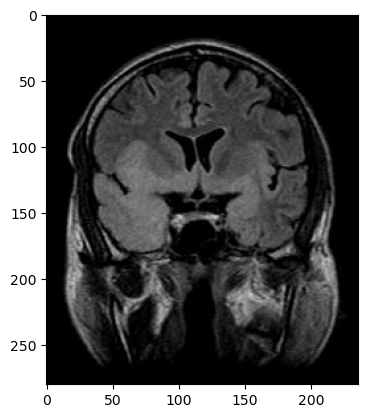

In [37]:
#Multi image classification model
from tensorflow.keras.preprocessing import image
from keras.utils import load_img
from tensorflow.keras.models import load_model
import matplotlib.image as img


d={0:'glioma', 1:'meningioma', 2:'notumor', 3:'pituitary'}
image_path='Training/notumor/Tr-no_0045.jpg'
classifier = load_model('brain_tumor.h5')
test_image = load_img(image_path,target_size = (128,128,3))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
result = classifier.predict(test_image)
print(result)
print(np.argmax(result))
testImage = img.imread(image_path)

# displaying the modified image
plt.imshow(testImage)
print("The category = ",d[np.argmax(result)])